In [ ]:
!pip install pytorch_pretrained_bert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install torch_snippets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import sys
import numpy as np
import random as rnfv
import pandas as pd

from sklearn.utils.multiclass import unique_labels
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from torch.nn.utils.rnn import pad_sequence
from torch_snippets import *
from torchmetrics import ConfusionMatrix, F1Score

from pytorch_pretrained_bert import BertModel
from pytorch_pretrained_bert import BertTokenizer

In [ ]:
# Data
train_data_path = 'agr_en_train.csv' # Path of data
valid_data_path = 'agr_en_dev.csv' # Path of data
print('Train data path:', train_data_path)
print('Valid data path:', valid_data_path)

batch_size = 8  # Batch size

# Preprocessing
word_max_len = 64

# Model
h1 = 768
h2 = 128
drop_out_rate = 0.2

# Training
epochs = 20  # Train epochs
learning_rate = 3e-6

Train data path: agr_en_train.csv

Valid data path: agr_en_dev.csv

In [ ]:
# Train
train_df = pd.read_csv(train_data_path, names = ['SOURCE', 'TEXT', 'AGGRESSION_CLASS'], 
                   usecols=['TEXT', 'AGGRESSION_CLASS'])
print('Column of df:', list(train_df))
print('Size of data:', len(train_df))
train_df.head()

Column of df:
['TEXT', 'AGGRESSION_CLASS']

Size of data: 12000

,TEXT,AGGRESSION_CLASS
0,Well said sonu..you have courage to stand agai...,OAG
1,"Most of Private Banks ATM's Like HDFC, ICICI e...",NAG
2,"Now question is, Pakistan will adhere to this?",OAG
3,Pakistan is comprised of fake muslims who does...,OAG
4,"??we r against cow slaughter,so of course it w...",NAG


In [ ]:
valid_df = pd.read_csv(valid_data_path, names = ['SOURCE', 'TEXT', 'AGGRESSION_CLASS'], 
                   usecols=['TEXT', 'AGGRESSION_CLASS'])
print('Column of df:', list(valid_df))
print('Size of data:', len(valid_df))
valid_df.head()

Column of df:
['TEXT', 'AGGRESSION_CLASS']

Size of data: 3001

,TEXT,AGGRESSION_CLASS
0,The quality of re made now makes me think it i...,CAG
1,@siva \nHow is ur mother???\nHow is ur wife???...,NAG
2,Also see ....hw ur RSS activist caught in Burk...,NAG
3,On the death of 2 jawans in LOC CROSS FIRING\n...,NAG
4,Modi ho ya Manmohan singh saala yeh log kuch n...,OAG


In [ ]:
# Shuffle data
np.random.seed(41)
train_shuffled = train_df.reindex(np.random.permutation(train_df.index))
valid_shuffled = valid_df.reindex(np.random.permutation(valid_df.index))

In [ ]:
# Train
CAG = train_shuffled[train_shuffled['AGGRESSION_CLASS'] == 'CAG']
OAG = train_shuffled[train_shuffled['AGGRESSION_CLASS'] == 'OAG']
NAG = train_shuffled[train_shuffled['AGGRESSION_CLASS'] == 'NAG']

concated_train = pd.concat([CAG, OAG, NAG], ignore_index=True)
concated_train['LABEL'] = 0

# Class to idx
concated_train.loc[concated_train['AGGRESSION_CLASS'] == 'CAG', 'LABEL'] = 0
concated_train.loc[concated_train['AGGRESSION_CLASS'] == 'OAG', 'LABEL'] = 1
concated_train.loc[concated_train['AGGRESSION_CLASS'] == 'NAG', 'LABEL'] = 2

# Valid
CAG = valid_shuffled[valid_shuffled['AGGRESSION_CLASS'] == 'CAG']
OAG = valid_shuffled[valid_shuffled['AGGRESSION_CLASS'] == 'OAG']
NAG = valid_shuffled[valid_shuffled['AGGRESSION_CLASS'] == 'NAG']

concated_valid = pd.concat([CAG, OAG, NAG], ignore_index=True)
concated_valid['LABEL'] = 0

# Class to idx
concated_valid.loc[concated_valid['AGGRESSION_CLASS'] == 'CAG', 'LABEL'] = 0
concated_valid.loc[concated_valid['AGGRESSION_CLASS'] == 'OAG', 'LABEL'] = 1
concated_valid.loc[concated_valid['AGGRESSION_CLASS'] == 'NAG', 'LABEL'] = 2

In [ ]:
# X data
X_train = concated_train['TEXT']
X_valid = concated_valid['TEXT']
in_features = len(list(X_train))
X_train.head()

0    Why some people are against to every step of M...
1    One thing i wonder about former RM LALU ji is ...
2    A speech full of just superficial ideas. Mr. M...
3    "tough competition for Royal Enfield"\nRoyal E...
4    why you guys are reporting to see us , where i...
Name: TEXT, dtype: object

In [ ]:
# Class info
class_list = ['CAG', 'OAG', 'NAG']
print('Class list:', class_list)
class_num = len(class_list)
print('Number of class:', class_num)

Class list:
['CAG', 'OAG', 'NAG']

Number of class: 3

In [ ]:
train_shuffled['AGGRESSION_CLASS'].value_counts()

NAG    5052
CAG    4240
OAG    2708
Name: AGGRESSION_CLASS, dtype: int64

In [ ]:
valid_shuffled['AGGRESSION_CLASS'].value_counts()

NAG    1233
CAG    1057
OAG     711
Name: AGGRESSION_CLASS, dtype: int64

In [ ]:
# one-hot encoding
y_train = to_categorical(concated_train['LABEL'], num_classes=3)
y_valid = to_categorical(concated_valid['LABEL'], num_classes=3)
print('Size of train labels:', y_train.shape)
print('Size of valid labels:', y_valid.shape)

Size of train labels:
(12000, 3)

Size of valid labels:
(3001, 3)

In [ ]:
class BertData(Dataset):
    def __init__(self, X, y, word_max_len):
        super().__init__()
        
        self.X = X
        self.y = y
        
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
        tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t) + ['[SEP]'], self.X))
        self.tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, tokens)), 
                                   maxlen=word_max_len, truncating="post", padding="post", dtype="int")
        self.masks = [[float(i > 0) for i in ii] for ii in self.tokens_ids]
        
        print('Token ids size:', self.tokens_ids.shape)
        print('Masks size:', np.array(self.masks).shape)
        print('y size:', np.array(self.y).shape)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, ind):
        tokens_id = self.tokens_ids[ind]
        label = self.y[ind]
        mask = self.masks[ind]
        return tokens_id, label, mask
    
    def collate_fn(self, data):
        tokens_ids, labels, masks = zip(*data)
        tokens_ids = torch.tensor(tokens_ids).to(device)
        labels = torch.tensor(labels).float().to(device)
        masks = torch.tensor(masks).to(device)
        return tokens_ids, labels, masks
    
    def choose(self):
        return self[np.random.randint(len(self))]

# New Section

In [ ]:
# Train
train_dataset = BertData(X_train, y_train, word_max_len)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size,
                      collate_fn=train_dataset.collate_fn)

# Valid
validate_dataset = BertData(X_valid, y_valid, word_max_len)
validate_sampler = SequentialSampler(validate_dataset)
validate_dataloader = DataLoader(validate_dataset, sampler=validate_sampler, batch_size=batch_size,
                    collate_fn=validate_dataset.collate_fn)

100%|██████████| 231508/231508 [00:00<00:00, 2714629.79B/s]


Token ids size:
(12000, 64)

Masks size:
(12000, 64)

y size:
(12000, 3)

Token ids size:
(3001, 64)

Masks size:
(3001, 64)

y size:
(3001, 3)

In [ ]:
inspect(*next(iter(train_dataloader)), names='tokens_ids, labels, masks')

══════════════════════════════════════════════════════════════════

TOKENS_IDS:
Tensor  Shape: torch.Size([8, 64])      Min: 0.000      Max: 29292.000  Mean: 2097.740  dtype: torch.int64 @ cuda:0

══════════════════════════════════════════════════════════════════

LABELS:
Tensor  Shape: torch.Size([8, 3])       Min: 0.000      Max: 1.000      Mean: 0.333     dtype: torch.float32 @ 
cuda:0

══════════════════════════════════════════════════════════════════

MASKS:
Tensor  Shape: torch.Size([8, 64])      Min: 0.000      Max: 1.000      Mean: 0.539     dtype: torch.float32 @ 
cuda:0

══════════════════════════════════════════════════════════════════

In [ ]:
class Bert_Aggression_Identification_Model(nn.Module):
    def __init__(self, h1, h2, class_num, drop_out_rate):
        super(Bert_Aggression_Identification_Model, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')

        self.dropout = nn.Dropout(drop_out_rate)
        self.linear1 = nn.Linear(h1, h2)
        self.linear2 = nn.Linear(h2, class_num)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
    
    def forward(self, tokens, masks):
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)
        d = self.dropout(pooled_output)
        x = self.relu(self.linear1(d))
        proba = self.softmax(self.linear2(x))
        
        return proba

In [ ]:
def train(data, model, optimizer, loss_fn):
    
    # Set train
    model.train()
    
    # Get batch data
    tokens_ids, labels, masks = data
    
    # Inference
    outputs = model(tokens_ids, masks)
    
    # Get loss
    loss = loss_fn(outputs, labels)
    
    # Get class
    preds = outputs.argmax(-1)
    labels = labels.argmax(-1)
    
    acc = (sum(preds==labels) / len(labels))
    
    # Init gradient
    model.zero_grad()
    
    # Backword propagation
    loss.backward()
    
    # Optimization 
    optimizer.step()
    
    return loss, acc

In [ ]:
@torch.no_grad()
def validate(data, model, loss_fn):
    
    # Set valid
    model.eval()
    
    # Get batch data
    tokens_ids, labels, masks = data
    
    # Inference
    outputs = model(tokens_ids, masks)
    
    # Get loss
    loss = loss_fn(outputs, labels)
    
    # Get class
    preds = outputs.argmax(-1)
    labels = labels.argmax(-1)
    
    acc = (sum(preds==labels) / len(labels))
    
    total_predict.extend(list(preds.cpu().numpy()))
    total_label.extend(list(labels.cpu().numpy()))
    
    return loss, acc

In [ ]:
log = Report(epochs)

# Convert to cuda
model = Bert_Aggression_Identification_Model(h1, h2, class_num, drop_out_rate).to(device)

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Gradient sceduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

100%|██████████| 407873900/407873900 [00:12<00:00, 33448491.82B/s]


In [ ]:
for epoch in range(epochs):
    n_batch = len(train_dataloader)
    for i, data in enumerate(train_dataloader):
        train_loss, train_acc = train(data, model, 
                                      optimizer, loss_fn)
        pos = epoch + ((i+1)/n_batch)
        log.record(pos=pos, train_loss=train_loss, 
                   train_acc=train_acc, end='\r')
        
    total_predict = []
    total_label = []

    n_batch = len(validate_dataloader)
    for i, data in enumerate(validate_dataloader):
        val_loss, val_acc = validate(data, model, loss_fn)
        pos = epoch + ((i+1)/n_batch)
        log.record(pos=pos, val_loss=val_loss, val_acc=val_acc, 
                   end='\r')
    
    scheduler.step()
    log.report_avgs(epoch+1)

EPOCH: 1.000  train_acc: 0.471  train_loss: 1.046  val_acc: 0.555  val_loss: 0.979  (230.95s - 4388.12s remaining)
EPOCH: 2.000  train_acc: 0.587  train_loss: 0.955  val_acc: 0.596  val_loss: 0.940  (438.51s - 3946.60s remaining)
EPOCH: 3.000  train_acc: 0.643  train_loss: 0.905  val_acc: 0.543  val_loss: 0.986  (645.79s - 3659.49s remaining)
EPOCH: 4.000  train_acc: 0.681  train_loss: 0.869  val_acc: 0.595  val_loss: 0.941  (853.63s - 3414.53s remaining)
EPOCH: 5.000  train_acc: 0.712  train_loss: 0.837  val_acc: 0.607  val_loss: 0.929  (1060.98s - 3182.93s remaining)
EPOCH: 6.000  train_acc: 0.740  train_loss: 0.810  val_acc: 0.615  val_loss: 0.925  (1268.15s - 2959.02s remaining)
EPOCH: 7.000  train_acc: 0.762  train_loss: 0.789  val_acc: 0.613  val_loss: 0.927  (1475.41s - 2740.04s remaining)
EPOCH: 8.000  train_acc: 0.775  train_loss: 0.775  val_acc: 0.605  val_loss: 0.934  (1682.67s - 2524.00s remaining)
EPOCH: 9.000  train_acc: 0.792  train_loss: 0.758  val_acc: 0.604  val_loss:

100%|██████████| 121/121 [00:01<00:00, 90.17it/s]


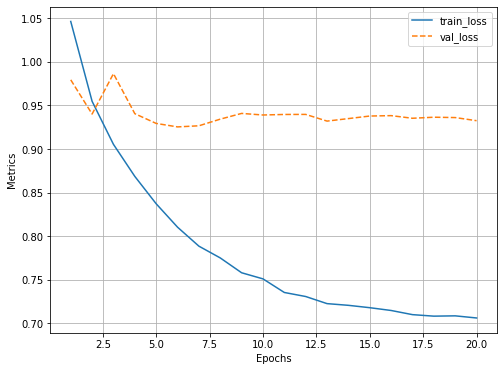

In [ ]:
log.plot_epochs(['train_loss', 'val_loss']) 

100%|██████████| 121/121 [00:00<00:00, 138.64it/s]


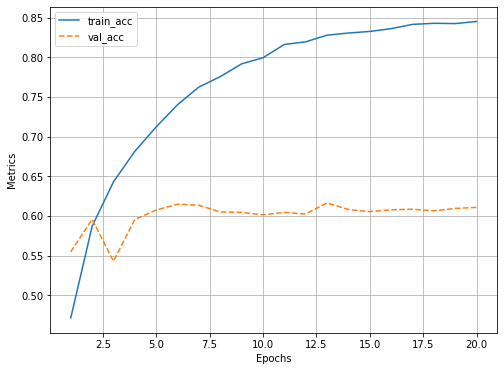

In [ ]:
log.plot_epochs(['train_acc', 'val_acc'])


In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_list,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    confmat = ConfusionMatrix(task="multiclass",num_classes=len(class_list))
    cm = confmat(torch.tensor(y_pred), torch.tensor(y_true)).cpu().numpy()
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=class_list, yticklabels=class_list,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
len(total_label), len(total_predict)

(3001, 3001)

In [ ]:
# F1 score
f1 = F1Score(task="multiclass" ,num_classes=len(class_list))
print('F1 scores:', f1(torch.tensor(total_label), torch.tensor(total_predict)))

F1 scores: tensor 0.610

Confusion matrix, without normalization

[[606 194 257]
 [278 370  63]
 [309  70 854]]

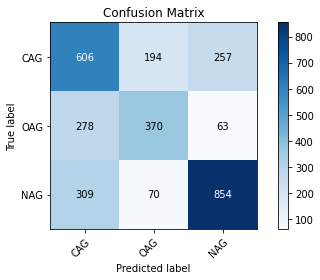

In [ ]:
# Confusion Matrix
plot_confusion_matrix(np.array(total_label), np.array(total_predict), class_list=class_list, normalize=False,
                      title='Confusion Matrix')